# Your First GAN: Generating Handwritten Letters

In [1]:
import emnist
from keras.datasets import mnist

from keras.layers import (Input, Dense, Reshape, Flatten, BatchNormalization, Conv2DTranspose,
                         SeparableConv2D, UpSampling2D, Dropout, Conv2D, UpSampling2D, Dropout)
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

Using TensorFlow backend.


In [2]:
def gen_fake(gen, batch_size, normal_noise=True):
    fake = gen.predict(gen_noise(batch_size, normal=normal_noise))
    return fake

def sample_real(real, batch_size):
    real = real[np.random.randint(0, len(real), size=batch_size)]
    return real

def gen_noise(batch_size, normal=True):
    if normal:
        return np.random.normal(size=(batch_size, z_dim))
    else:
        return np.random.uniform(-1, 1, (batch_size, z_dim))

def get_training_set(real=[], fake=[]):
    if len(real) == 0:
        x_batch = fake
    elif len(fake) == 0:
        x_batch = real
    else:
        x_batch = np.concatenate([fake, real])
    y_batch = np.concatenate([np.zeros(len(fake)), np.ones(len(real))])
    return x_batch, y_batch

In [3]:
def get_history_summary(histories):
    fields = ["acc", "loss", "val_acc", "val_loss"]
    history = {}
    
    for field in fields:
        vals = [history.history.get(field, 0)[-1] for history in histories]
        history[field] = np.round(np.median(vals),4)
    
    lens = np.median([len(history.history.get(fields[0])) for history in histories])
    history["num_epochs"] = lens
    
    return history

def display_gen(gan, n_samples, real=None, fname=None, show=True, num_cols=15):
    gen, disc = gan.layers[1:3]
    
    if real is not None:
        n_real = n_samples // 2
        n_fake = n_samples // 2  + n_samples % 2 # add 1 if n_samples is odd
    else:
        n_real = 0
        n_fake = n_samples
    
    # Fake
    noise = gen_noise(n_fake)    
    fake_samples = gen.predict(noise)
    
    # Real
    if n_real > 0:
        real_samples = sample_real(real, n_real)
        samples = np.concatenate([fake_samples, real_samples])
        is_reals = np.concatenate([np.repeat(False, n_fake), np.repeat(True, n_real)])
    else:
        samples = fake_samples
        is_reals = np.repeat(False, n_fake)
        
    disc_out = disc.predict(samples)
    
    ims = (samples + 1) / 127.5 
    ims = ims.squeeze(axis=-1)
    
    predicts = np.round(disc_out,2).squeeze()
    
    examples = sorted(zip(ims,is_reals,predicts),key=lambda x: x[2])
    
    ncols = min(n_samples, num_cols)
    nrows = (n_samples - 1) // ncols + 1
    
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    f.set_size_inches(ncols * 2, nrows * 2.5)
    
    plt.xticks([])
    plt.yticks([])
    
    if n_samples == 1:
        axes = [axes]
        
    for ax, (ex, is_real, predict) in zip(axes.ravel(), examples):
        ax.imshow(ex)
        if is_real:
            color="xkcd:dark green"
        else:
            color="xkcd:bright red"
        ax.set_title(predict, color=color,fontsize=30)
    
    plt.tight_layout()
    if fname:
        plt.savefig(fname=fname)
        plt.close()
    else:
        plt.show()

In [4]:
def generator(img_shape, z_dim):
    inp = Input(shape=(z_dim,), name="noise")
    
    # Dense
    x = Dense(7 * 7 * 256, name="gen_dense")(inp)
    x = LeakyReLU(alpha=0.01, name="gen_act")(x)
    x = BatchNormalization(name="gen_batch_norm")(x)
    
    x = Reshape([7,7,256], name="gen_reshape")(x)
    x = Dropout(0.4)(x)
    x = UpSampling2D(name="gen_up_sample")(x)

    # Transposed Convolution
    x = Conv2DTranspose(128, 5, padding="same", name="gen_conv_1")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_1")(x)
    x = BatchNormalization(name="gen_batch_norm_1")(x)
    x = UpSampling2D(name="gen_up_sample_1")(x)

    # Transposed Convolution
    x = Conv2DTranspose(64, 5, padding="same", name="gen_conv_2")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_2")(x)
    x = BatchNormalization(name="gen_batch_norm_2")(x)

    # Transposed Convolution
    x = Conv2DTranspose(32, 5, padding="same", name="gen_conv_3")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_3")(x)
    x = BatchNormalization(name="gen_batch_norm_3")(x)
    
    out = Conv2DTranspose(1, 5, padding="same", name="gen_conv_4", activation="tanh")(x)
    
    return Model(inp, out, name="generator")

def discriminator(img_shape):
    inp = Input(shape=[*img_shape, 1], name="image")
    
    x = Reshape([*img_shape, 1], name="disc_reshape")(inp)
    
    x = Conv2D(64, 5, strides=2, padding="same", name="disc_conv_1")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_1")(x)
#     x = BatchNormalization(name="disc_batch_norm_1")(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, 5, strides=2, padding="same", name="disc_conv_2")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_2")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(256, 5, strides=2, padding="same", name="disc_conv_3")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_3")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(512, 5, strides=1, padding="same", name="disc_conv_4")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_4")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    out = Dense(1, activation="sigmoid", name="disc_out")(x)

    return Model(inp, out, name="discriminator")

def generative_adversarial_model(img_shape, z_dim):
    gen = generator(img_shape, z_dim)
    disc = discriminator(img_shape)
    
    inp = Input(shape=(*gen.input_shape[1:],), name="image")
    img = gen(inp)

    # NOTE: When creating our gan, we do not want the discriminator to be trainable
    disc.trainable = False 

    prediction = disc(img)

    gan = Model(inp, prediction, name="gan")
    gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return gan

In [5]:
digit_size = 28
original_dim = (digit_size, digit_size)
batch_size = 1000

z_dim = 100

## Create the network

In [16]:
gan = generative_adversarial_model(img_shape=original_dim, z_dim=z_dim)
gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gan.summary()

gan.layers[1].summary() # generator
gan.layers[2].summary() # discriminator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         2394241   
_________________________________________________________________
discriminator (Model)        (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           (None, 100)               0         
_________________________________________________________________
gen_dense (Dense)            (None, 12544)             1266944   
__________________________________________________________

In [17]:
def train(gan,
          num_iters,
          batch_size=128, 
          print_every=1,
          epochs=1,
          min_disc_acc = 0.5,
          min_gan_acc = 0.2,
          normal_noise=True,
          save_example_name=None,
          save_model_name=None,
          validation_split=0.2,
          callbacks=[]
         ):
    """
        gan:               model consisting of a 
        num_iters:         number of iterations to run
        batch_size:        batch size of each training iteration
        print_every:       either an int that prints every n iterations or a list of iterations to print
        min_disc_acc:      minimum discriminator accuracy required to go on and train the generator 
        min_gen_acc:       minimum generator accuracy required to go on and train the discriminator
        normal_noise:      boolean that states whether the random noise input should be normally distributed or uniform
        save_example_name: name to save the example output
        save_model_name:   name to save the model
        epochs:            maximum number of epochs to run on each iteration
        validation_split:  percent of batch_size to serve as validation
        callbacks:         callbacks to run when training model
    """
    gen_history = History()
    disc_history = History()
    
    gen, disc = gan.layers[1:3]
    
    disc.trainable = True
    disc.compile(loss = gan.loss, optimizer = gan.optimizer, metrics= gan.metrics)
        
    if type(print_every) is int:
        print_every = np.arange(print_every, num_iters, print_every)
    print_every = set(print_every)
    
    actual_batch_size = int(batch_size / (1.0 - validation_split))
    
    for n in range(1, num_iters + 1):
        # Training the generator
        print("\rIteration: {}/{}".format(n, num_iters), end="")
        for epoch in range(1, epochs + 1):
            noise = gen_noise(actual_batch_size, normal=normal_noise)
            x_batch, y_batch = get_training_set(real=noise)
            h = gan.fit(x_batch, y_batch, epochs=1, verbose=0, validation_split=validation_split, callbacks=callbacks)
            gen_history.update(h)
            
            gan_epochs = epoch
            if gen_history.get_latest("val_acc") > min_gan_acc:
                break

        # Training the discriminator
        for epoch in range(1, epochs + 1):
            fake = gen_fake(gen, actual_batch_size // 2)
            real = sample_real(X_train, actual_batch_size // 2)
            x_batch, y_batch = get_training_set(real=real, fake=fake)
            x_batch = x_batch.reshape([-1, *disc.input_shape[1:]])
            h = disc.fit(x_batch, y_batch, epochs=1, verbose=0, validation_split=validation_split, callbacks=callbacks)
            disc_history.update(h)
            
            disc_epochs = epoch
            if disc_history.get_latest("val_acc") > min_disc_acc:
                break


        if n in print_every:
            print("""\nGen status:  {}. \nDisc status: {}""".format(gen_history, disc_history))

            if save_model_name:
                gan.save("{:05}_{}.h5".format(n, save_model_name))
            
            display_gen(gan, 10)

            if save_example_name:
                fname = "{:05}_{}.png".format(n, save_example_name)
                display_gen(gan, 15 * 15, real=X_train, fname=fname)

            gen_hists = []
            disc_hists = []
            
    return gen_history, disc_history 

In [18]:
class History:
    def __init__(self):
        self.history = []
        
    def update(self, history):
        self.history.append(history.history)
    
    def __str__(self):
        latest = self.history[-1]
        str_val = " ".join(["{}: {:.5f}".format(k, v[-1]) for k, v in self.history[-1].items()])
        str_val += " epochs: {}".format(len(self.history))
        return str_val
    
    def get_latest(self, val):
        return self.history[-1].get(val)[-1]


In [6]:
(X_train, _), (X_test, _) = emnist.load_data()
# (X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train / 127.5 - 1
X_test = X_test / 127.5 - 1

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


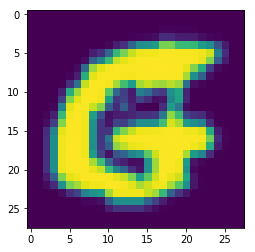

In [20]:
%matplotlib inline
plt.imshow(X_train[1].squeeze())

## Normal noise

Iteration: 1/5000

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



1 iteration. 
Gen status:  val_loss: 0.69608 val_acc: 0.25000 loss: 0.70158 acc: 0.39844 epochs: 4. 
Disc status: val_loss: 0.18264 val_acc: 0.96875 loss: 0.35883 acc: 0.83594 epochs: 2


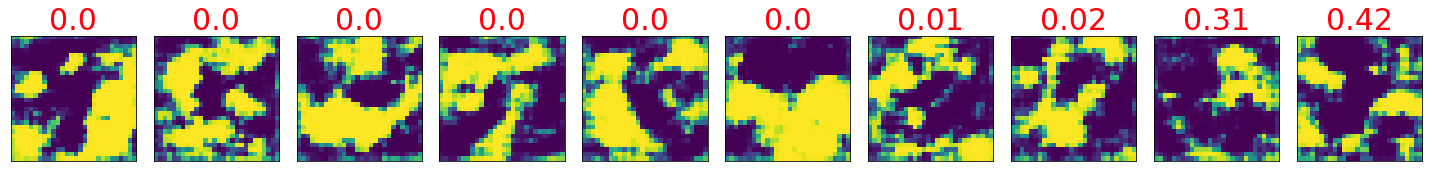

Iteration: 2/5000
2 iteration. 
Gen status:  val_loss: 0.67402 val_acc: 0.75000 loss: 1.26421 acc: 0.50000 epochs: 7. 
Disc status: val_loss: 0.14876 val_acc: 1.00000 loss: 1.02892 acc: 0.70312 epochs: 3


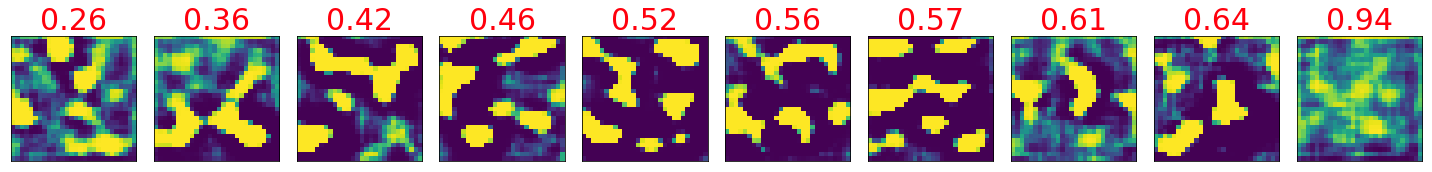

Iteration: 3/5000
3 iteration. 
Gen status:  val_loss: 0.81589 val_acc: 0.53125 loss: 0.60351 acc: 0.71875 epochs: 8. 
Disc status: val_loss: 0.41878 val_acc: 0.87500 loss: 0.43437 acc: 0.78906 epochs: 4


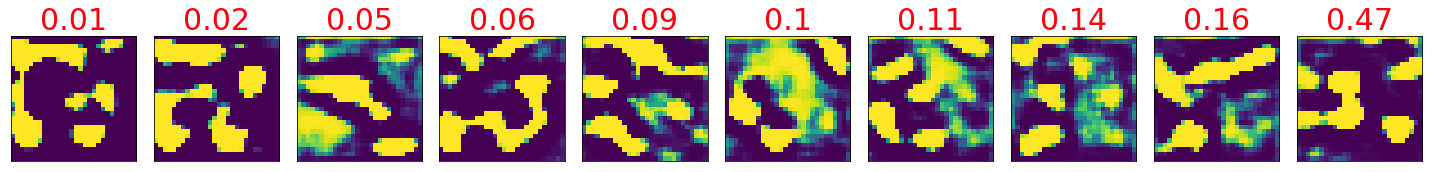

Iteration: 5/5000
5 iteration. 
Gen status:  val_loss: 1.85792 val_acc: 0.25000 loss: 1.06922 acc: 0.48438 epochs: 13. 
Disc status: val_loss: 0.11447 val_acc: 0.96875 loss: 0.18484 acc: 0.92188 epochs: 6


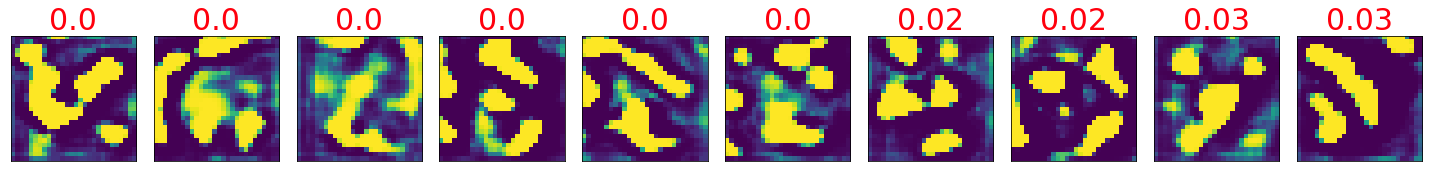

Iteration: 10/5000
10 iteration. 
Gen status:  val_loss: 0.84709 val_acc: 0.28125 loss: 0.70830 acc: 0.67969 epochs: 26. 
Disc status: val_loss: 0.58817 val_acc: 0.93750 loss: 0.57951 acc: 0.79688 epochs: 12


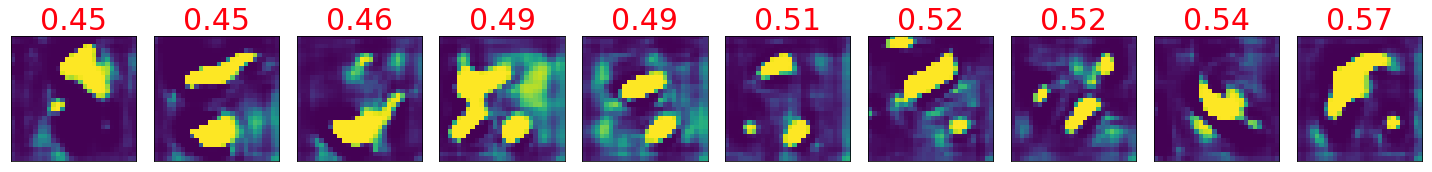

Iteration: 25/5000
25 iteration. 
Gen status:  val_loss: 0.86473 val_acc: 0.50000 loss: 0.91149 acc: 0.40625 epochs: 51. 
Disc status: val_loss: 0.81117 val_acc: 0.68750 loss: 0.53552 acc: 0.74219 epochs: 36


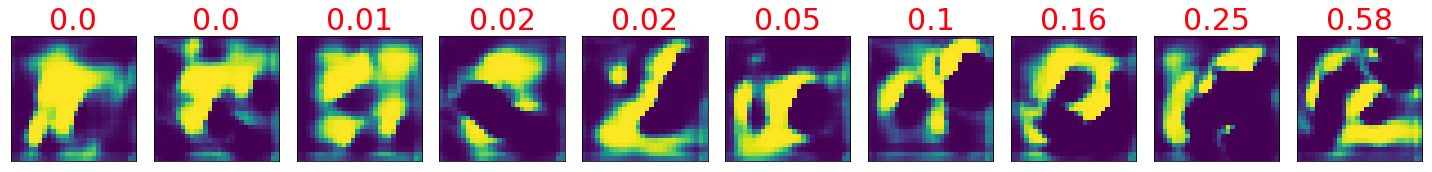

Iteration: 50/5000
50 iteration. 
Gen status:  val_loss: 0.96927 val_acc: 0.46875 loss: 1.93887 acc: 0.27344 epochs: 90. 
Disc status: val_loss: 0.60814 val_acc: 0.71875 loss: 0.50302 acc: 0.71875 epochs: 70


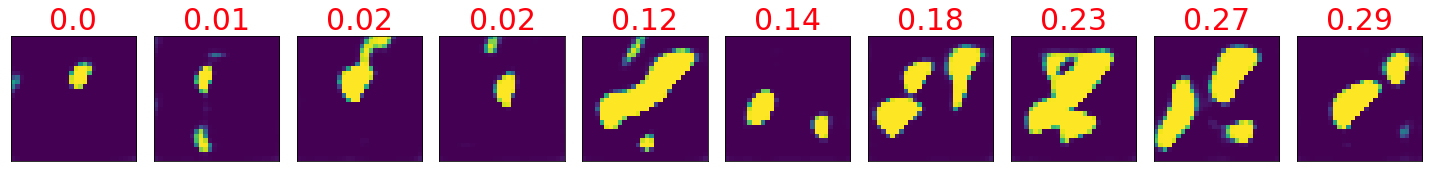

Iteration: 100/5000
100 iteration. 
Gen status:  val_loss: 1.04155 val_acc: 0.28125 loss: 1.29284 acc: 0.21875 epochs: 201. 
Disc status: val_loss: 0.77109 val_acc: 0.59375 loss: 0.50767 acc: 0.75000 epochs: 132


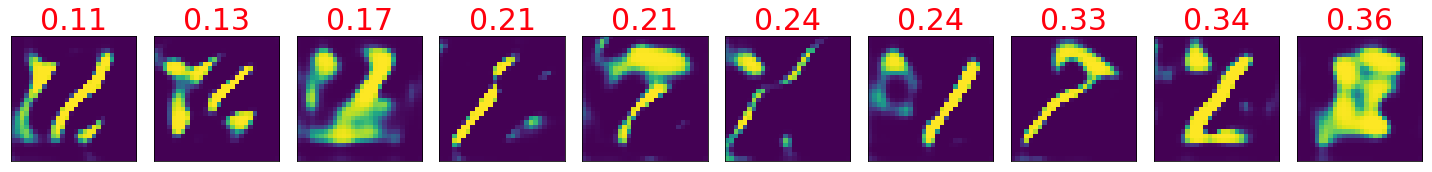

Iteration: 200/5000
200 iteration. 
Gen status:  val_loss: 1.09849 val_acc: 0.21875 loss: 1.43651 acc: 0.07812 epochs: 433. 
Disc status: val_loss: 0.64094 val_acc: 0.68750 loss: 0.58640 acc: 0.67188 epochs: 269


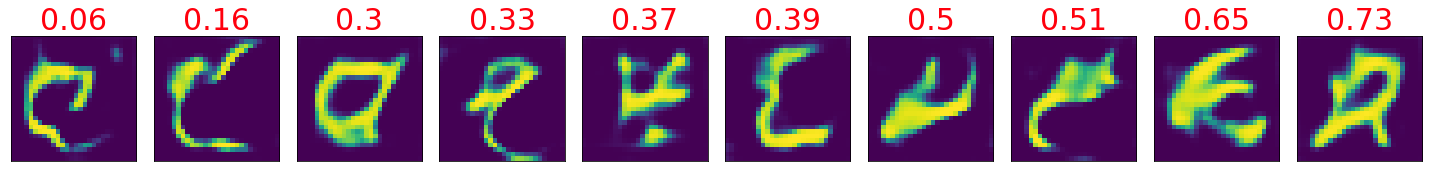

Iteration: 300/5000
300 iteration. 
Gen status:  val_loss: 0.77805 val_acc: 0.40625 loss: 1.10743 acc: 0.17969 epochs: 675. 
Disc status: val_loss: 0.50634 val_acc: 0.65625 loss: 0.44453 acc: 0.79688 epochs: 460


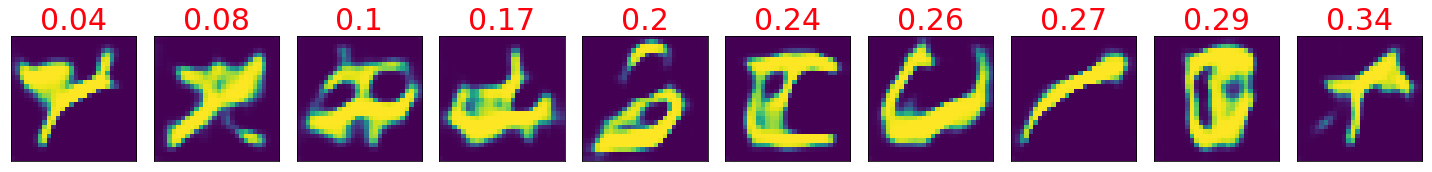

Iteration: 500/5000
500 iteration. 
Gen status:  val_loss: 1.08597 val_acc: 0.21875 loss: 1.12458 acc: 0.20312 epochs: 1270. 
Disc status: val_loss: 0.76290 val_acc: 0.53125 loss: 0.54059 acc: 0.71875 epochs: 836


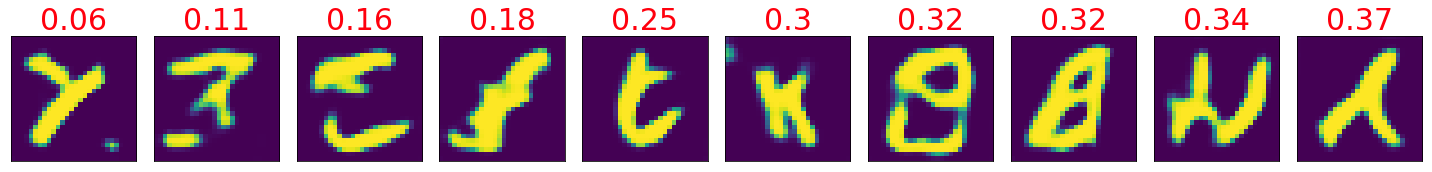

Iteration: 1000/5000
1000 iteration. 
Gen status:  val_loss: 0.86806 val_acc: 0.31250 loss: 1.44304 acc: 0.11719 epochs: 2965. 
Disc status: val_loss: 0.58305 val_acc: 0.65625 loss: 0.59590 acc: 0.68750 epochs: 1655


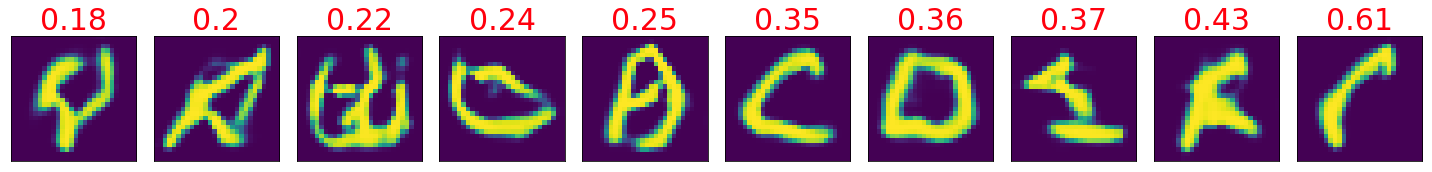

Iteration: 2000/5000
2000 iteration. 
Gen status:  val_loss: 0.99916 val_acc: 0.21875 loss: 1.33587 acc: 0.07812 epochs: 6644. 
Disc status: val_loss: 0.61404 val_acc: 0.62500 loss: 0.62473 acc: 0.66406 epochs: 3247


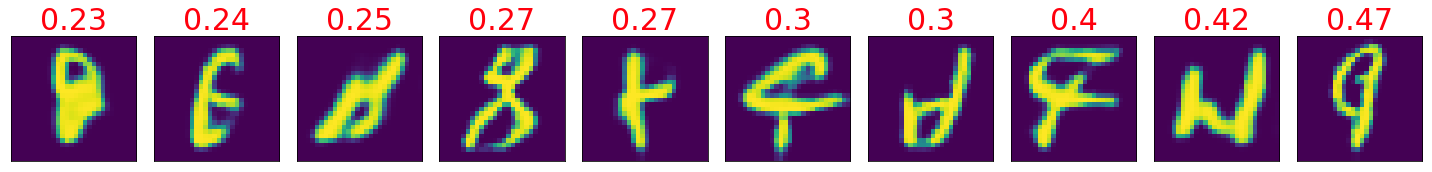

Iteration: 3000/5000
3000 iteration. 
Gen status:  val_loss: 1.04917 val_acc: 0.09375 loss: 1.21231 acc: 0.13281 epochs: 10520. 
Disc status: val_loss: 0.58586 val_acc: 0.65625 loss: 0.63995 acc: 0.63281 epochs: 5195


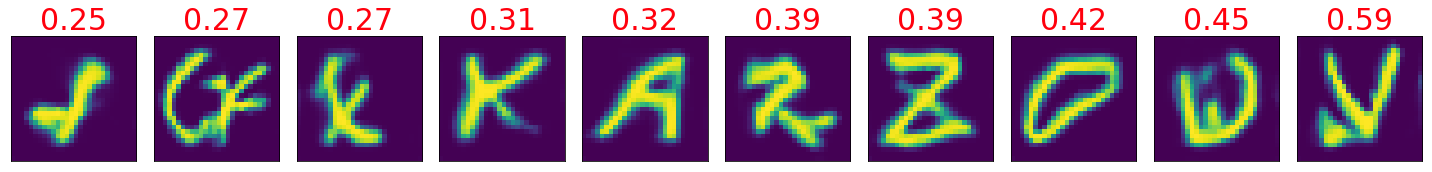

Iteration: 5000/5000
5000 iteration. 
Gen status:  val_loss: 1.01280 val_acc: 0.06250 loss: 1.14042 acc: 0.14062 epochs: 18777. 
Disc status: val_loss: 0.86484 val_acc: 0.34375 loss: 0.60258 acc: 0.69531 epochs: 10768


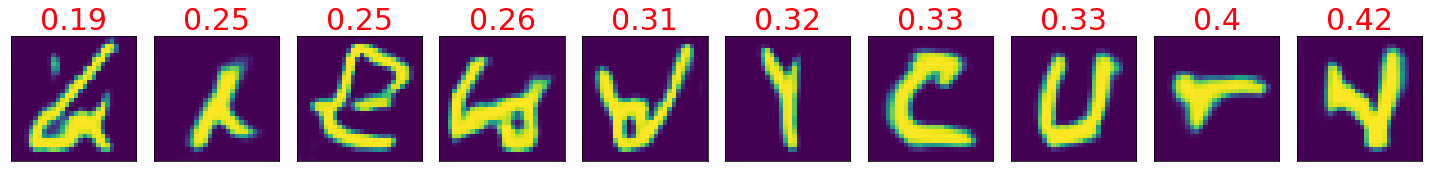

(<__main__.History at 0x7f1a42c7eb38>, <__main__.History at 0x7f1a42c7e080>)

In [21]:
train(gan=gan, 
      num_iters=5000, 
      epochs=5, 
      print_every=[1,2,3,5,10,25,50,100,200,300,500,1000,2000,3000,5000],
      save_example_name="5_epochs",
      save_model_name="gan",
      normal_noise=True)

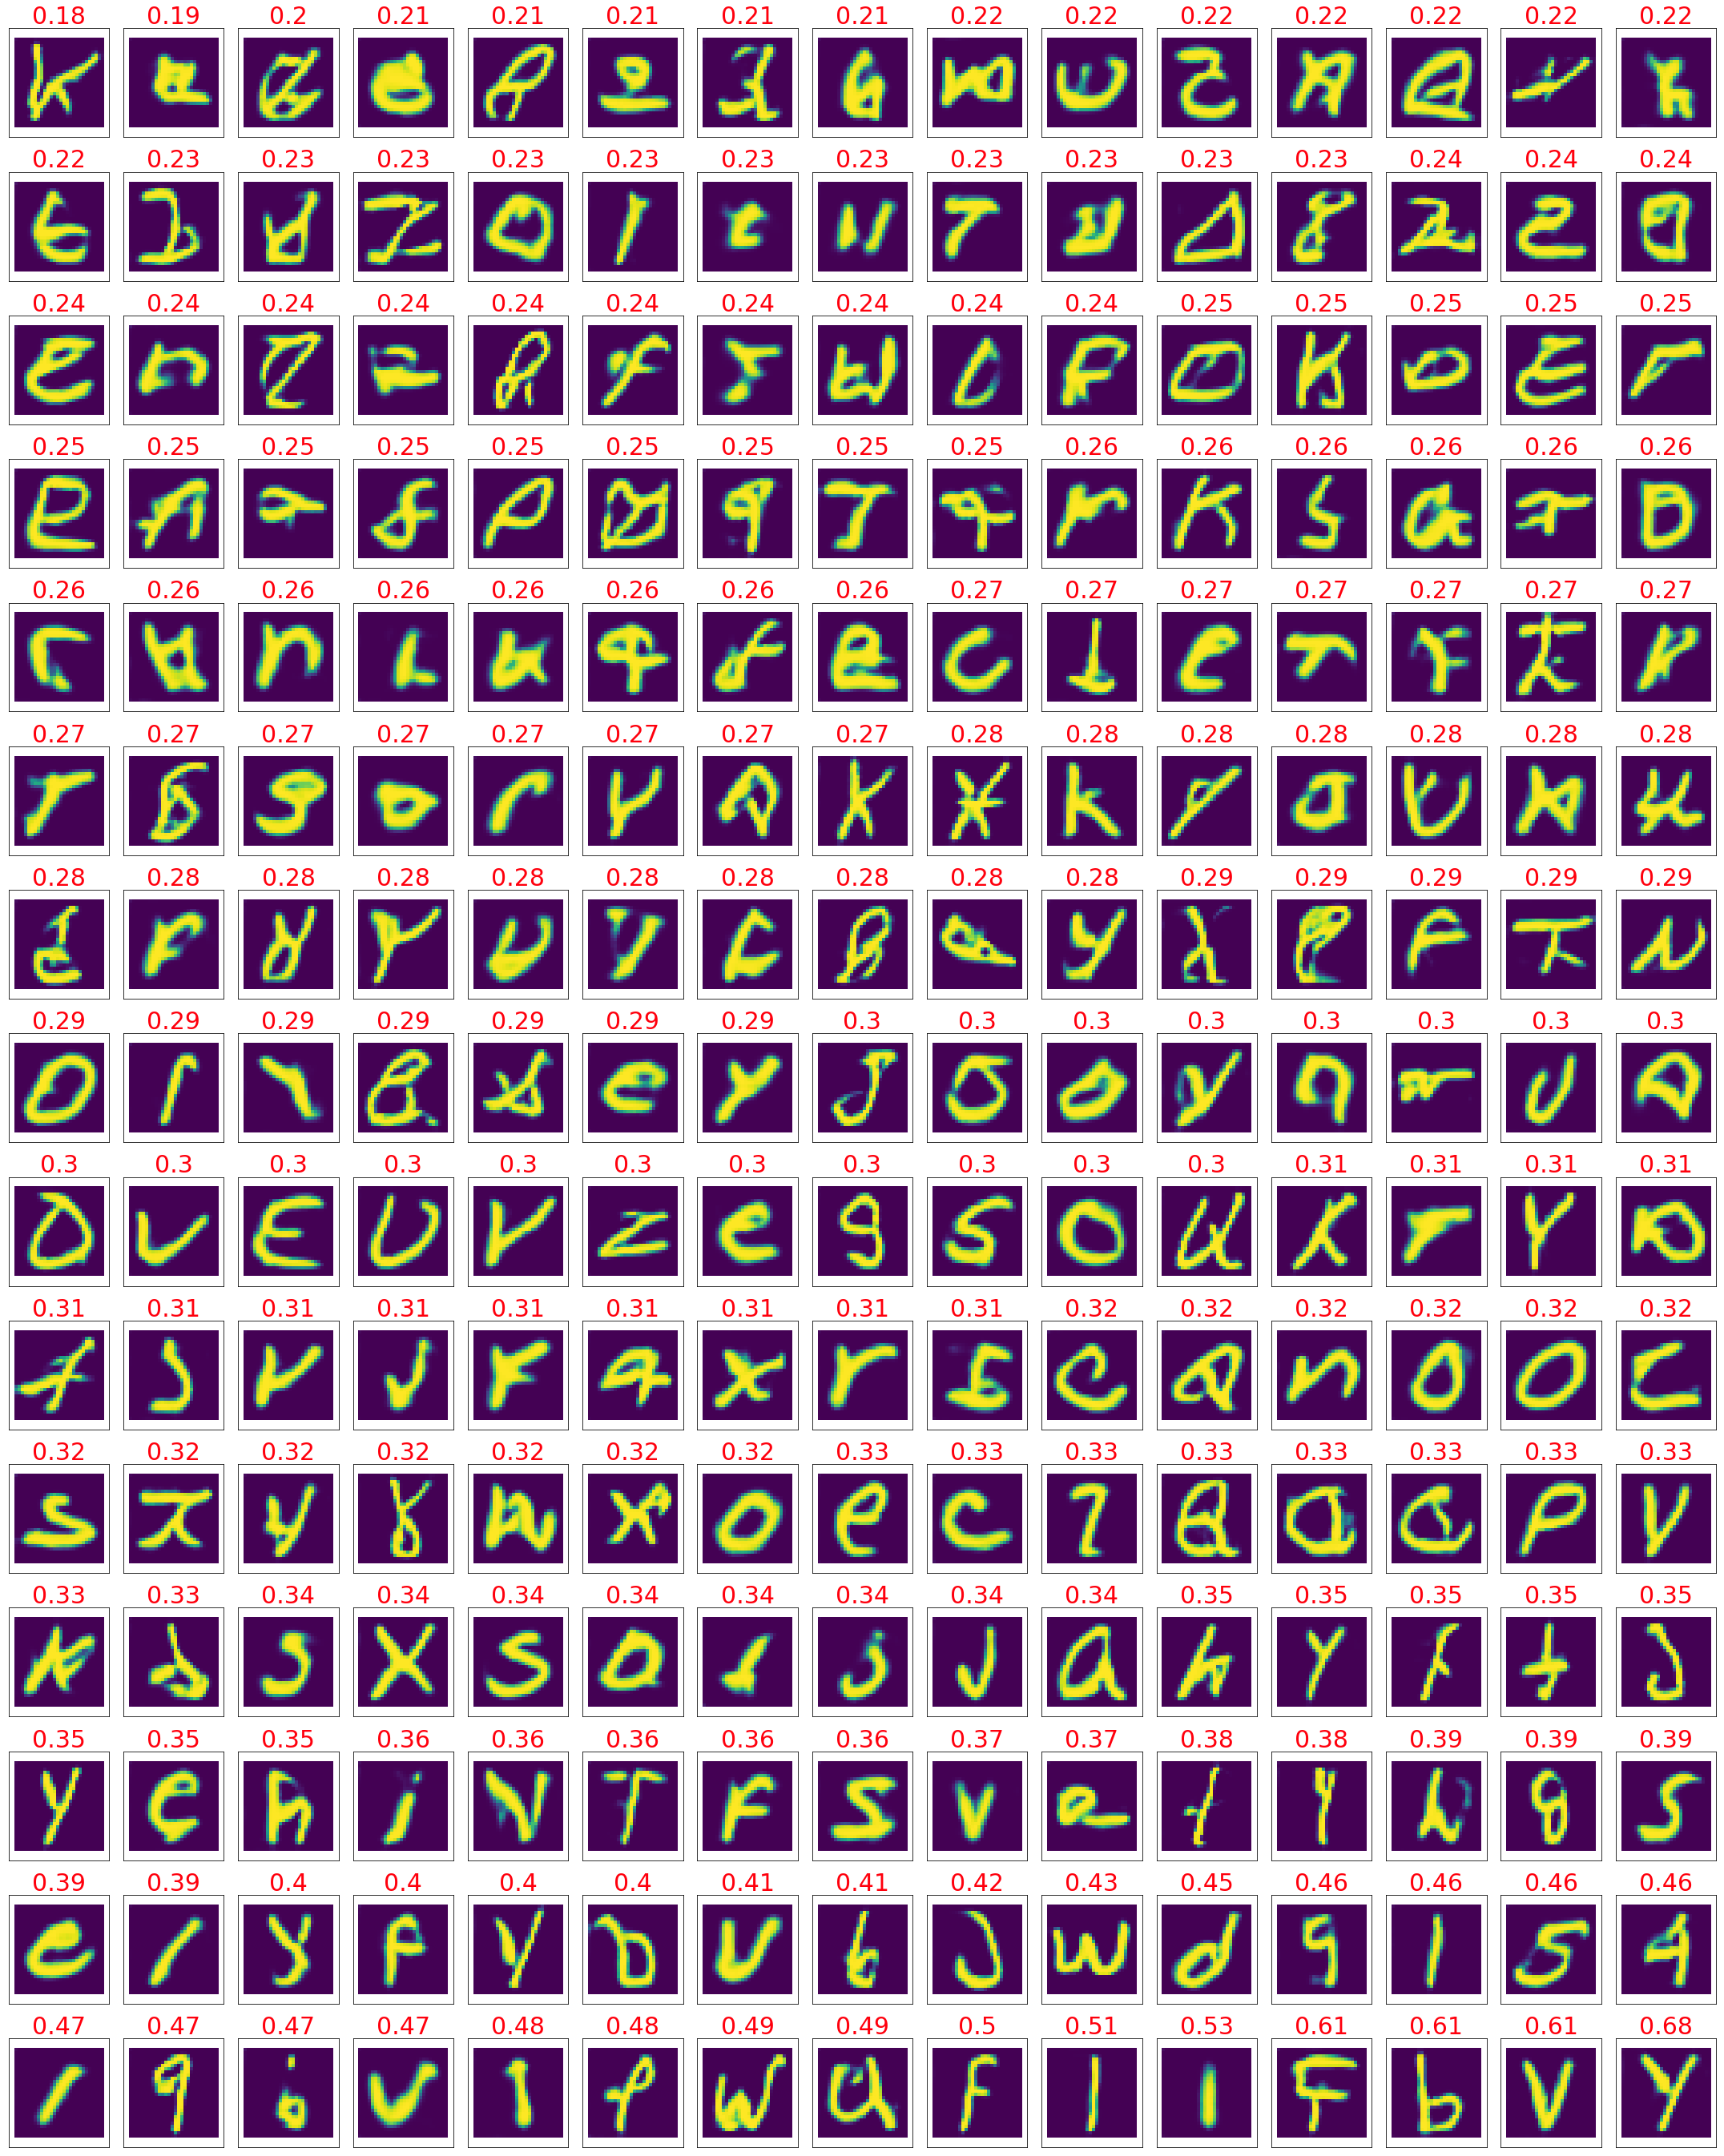

In [10]:
display_gen(gan, 15*15)